## Oversampling experiment
Author: Seongsu Jeong, Heresh Fattahi


### Purpose of the experiment
This experiment is to find out what how the oversampling grid is defined inside the FFT-based oversampling function of ISCE3.


### Oversampling grid
Two ways of oversampling grid definitions are in discussion. Let's assume that in the original samples, we have sampling grid of 0, 1, 2, ... N-1 (N samples total)

1. The oversampling grid can start from the center of the upperleft pixel in the oversampled image, with the spacing between the pixel is 1/ovs. Let's call this "area-based".
2. The oversampling grid can start from 0, which is the center of the upperleft pixel in original image. The spacing will be same as the area-based, so it will be like 0, 1/ovs, so 0, 1/ovs, 2/ovs, ... N-1/ovs, where `ovs` is oversampling factor. Let's call this "point-based approach"


The drawings for those different gridding scheme are as in the screenshots below:
![Area-based](Figs/area_based_grid.png)
![Point-based](Figs/point_based_grid.png)


### What is expected
- The oversampling function would take its own way of defining the oversampling grid, althouth it is implicit inside the function.
- If the "well-known" signal is sampled on the same oversampling grid as `isce3.signal.point_target_info.oversample()`, then the difference between the sampled signal and the oversampled signal will be very small.


The cell below is to define the "True signal" and sample that in the original grid i.e. before the oversampling

Text(0.5, 1.0, 'Oversampled by ISCE3\nfactor=4')

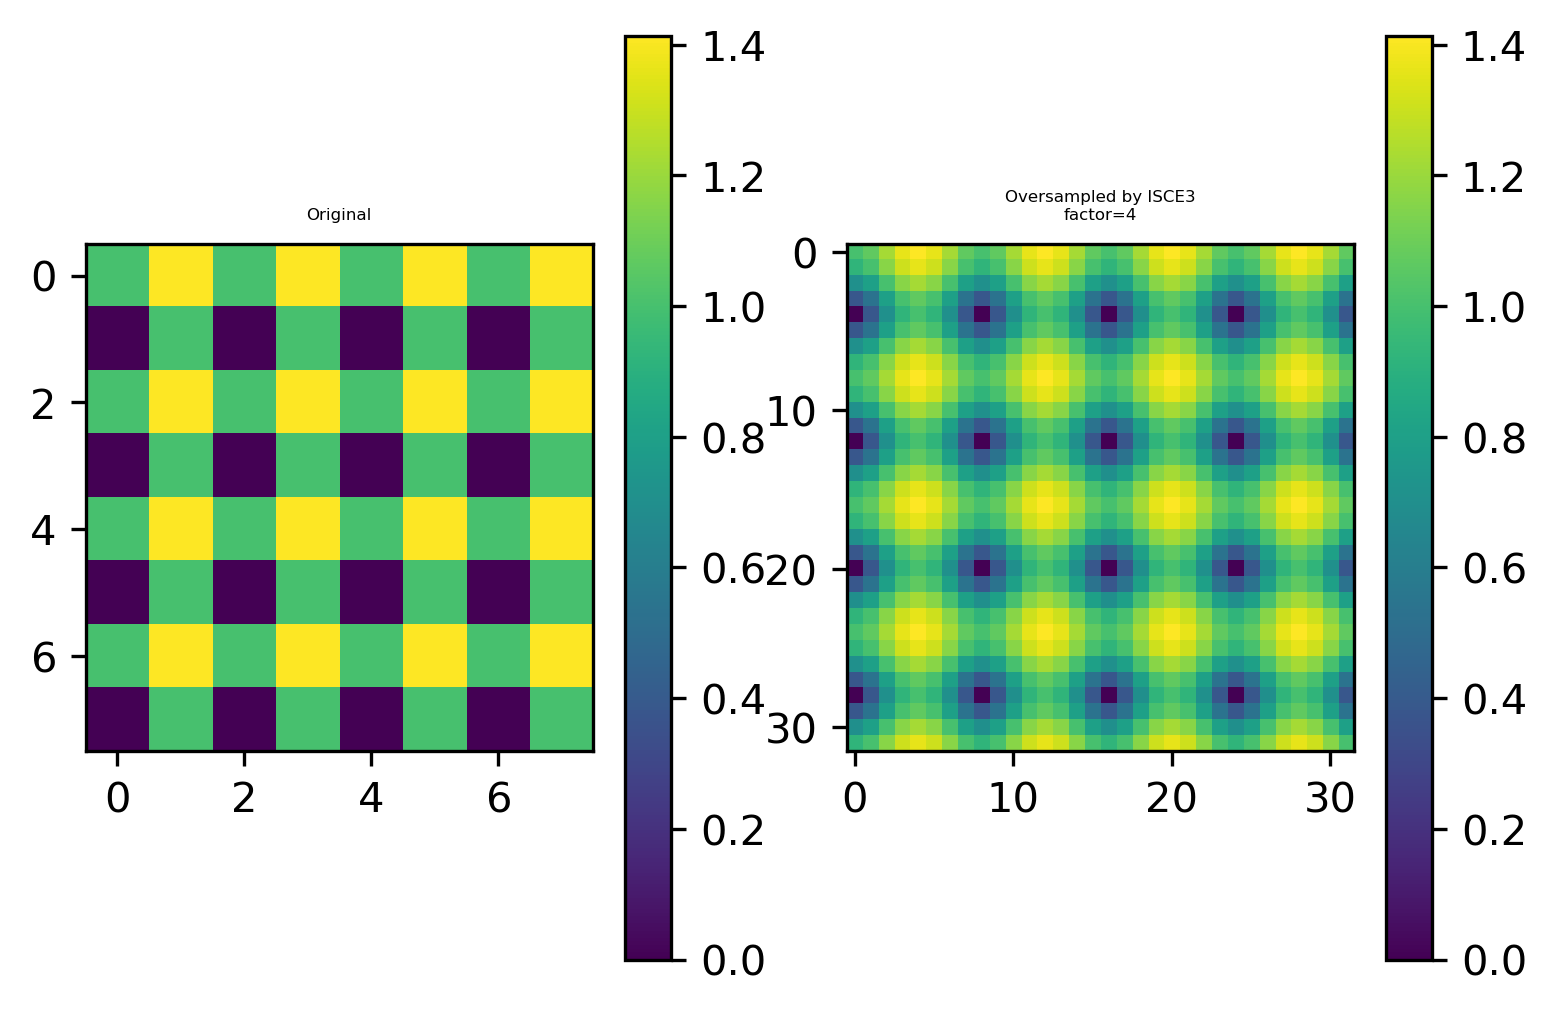

In [18]:
import isce3
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 300

# Define the "True" signal
def true_signal(x, y):
    arr_real = np.sin((x)*np.pi/2)
    arr_imag = np.cos((y)*np.pi/2)
    return arr_real + arr_imag*1.0j

# Define the grid in the original resolution i.e. before oversampling
N = 8 # number of samples in the original image chip
ovs = 4 # Oversampling factor

x_original = np.arange(N)
y_original = np.arange(N)
xx_original, yy_original = np.meshgrid(x_original, y_original)

# Do the sampling on the original grid
zz_original = true_signal(xx_original, yy_original)

# Oversample the original signal using ISCE
zz_ovs_isce3 = isce3.signal.point_target_info.oversample(zz_original, ovs)

# Visualize the amplitude
plt.subplot(1,2,1)
plt.imshow(np.abs(zz_original))
plt.colorbar()
plt.title('Original', size=4)

plt.subplot(1,2,2)
plt.imshow(np.abs(zz_ovs_isce3))
plt.colorbar()
plt.title(f'Oversampled by ISCE3\nfactor={ovs}', size=4)

The plot above is how the original image and the oversampling result look like.

Let's define the oversampling grids in the two different ways.

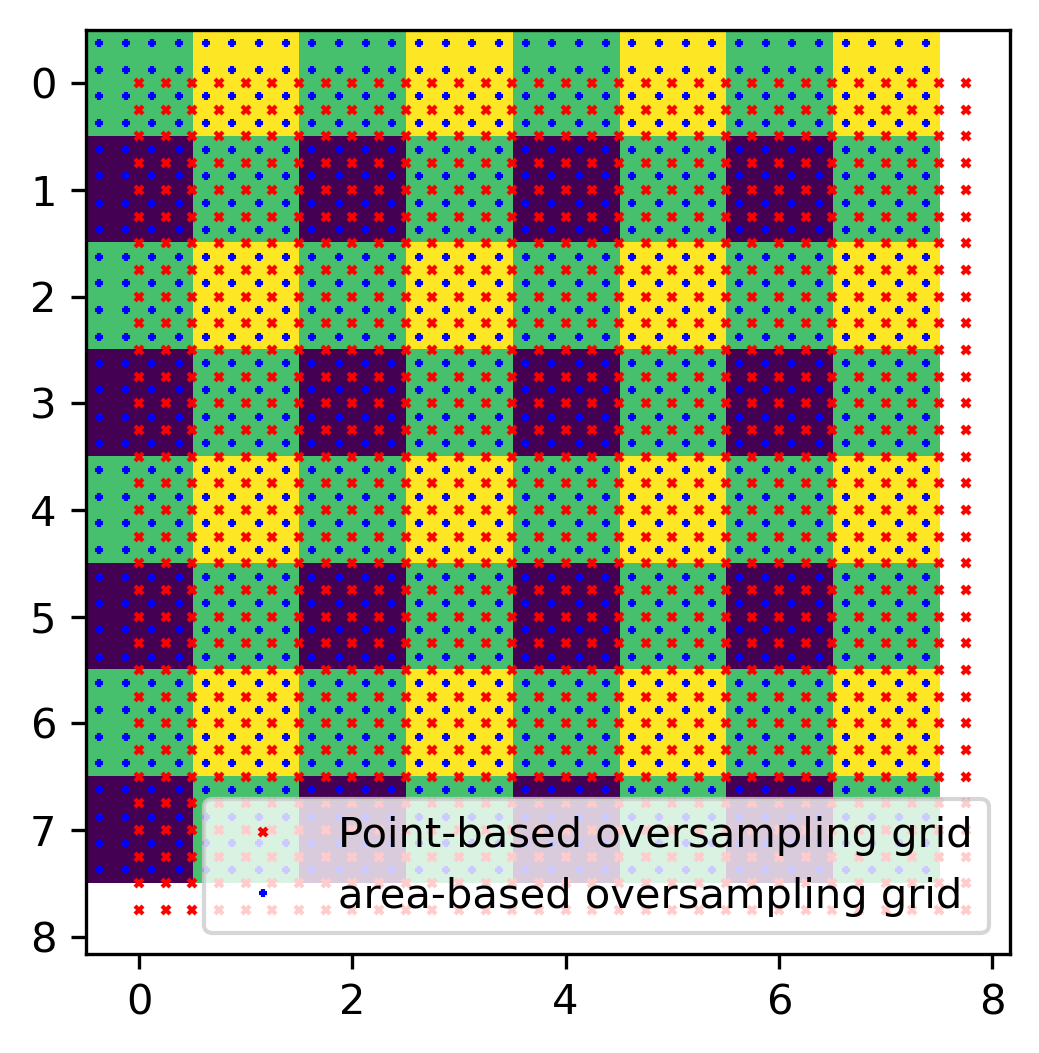

In [19]:

x_ovs_point = np.arange(N * ovs) / ovs
y_ovs_point = np.arange(N * ovs) / ovs
xx_ovs_point, yy_ovs_point = np.meshgrid(x_ovs_point, y_ovs_point)

x_ovs_area = np.arange(N * ovs) / ovs - (1 - 1/ovs)/2
y_ovs_area = np.arange(N * ovs) / ovs - (1 - 1/ovs)/2
xx_ovs_area, yy_ovs_area = np.meshgrid(x_ovs_area, y_ovs_area)


plt.imshow(np.abs(zz_original))
plt.plot(xx_ovs_point.flatten(), yy_ovs_point.flatten(), 'rx', markersize = 2, linewidth=0.1)
plt.plot(xx_ovs_area.flatten(), yy_ovs_area.flatten(), 'b+', markersize = 2, linewidth=0.1)
plt.legend(['Point-based oversampling grid', 'area-based oversampling grid'])


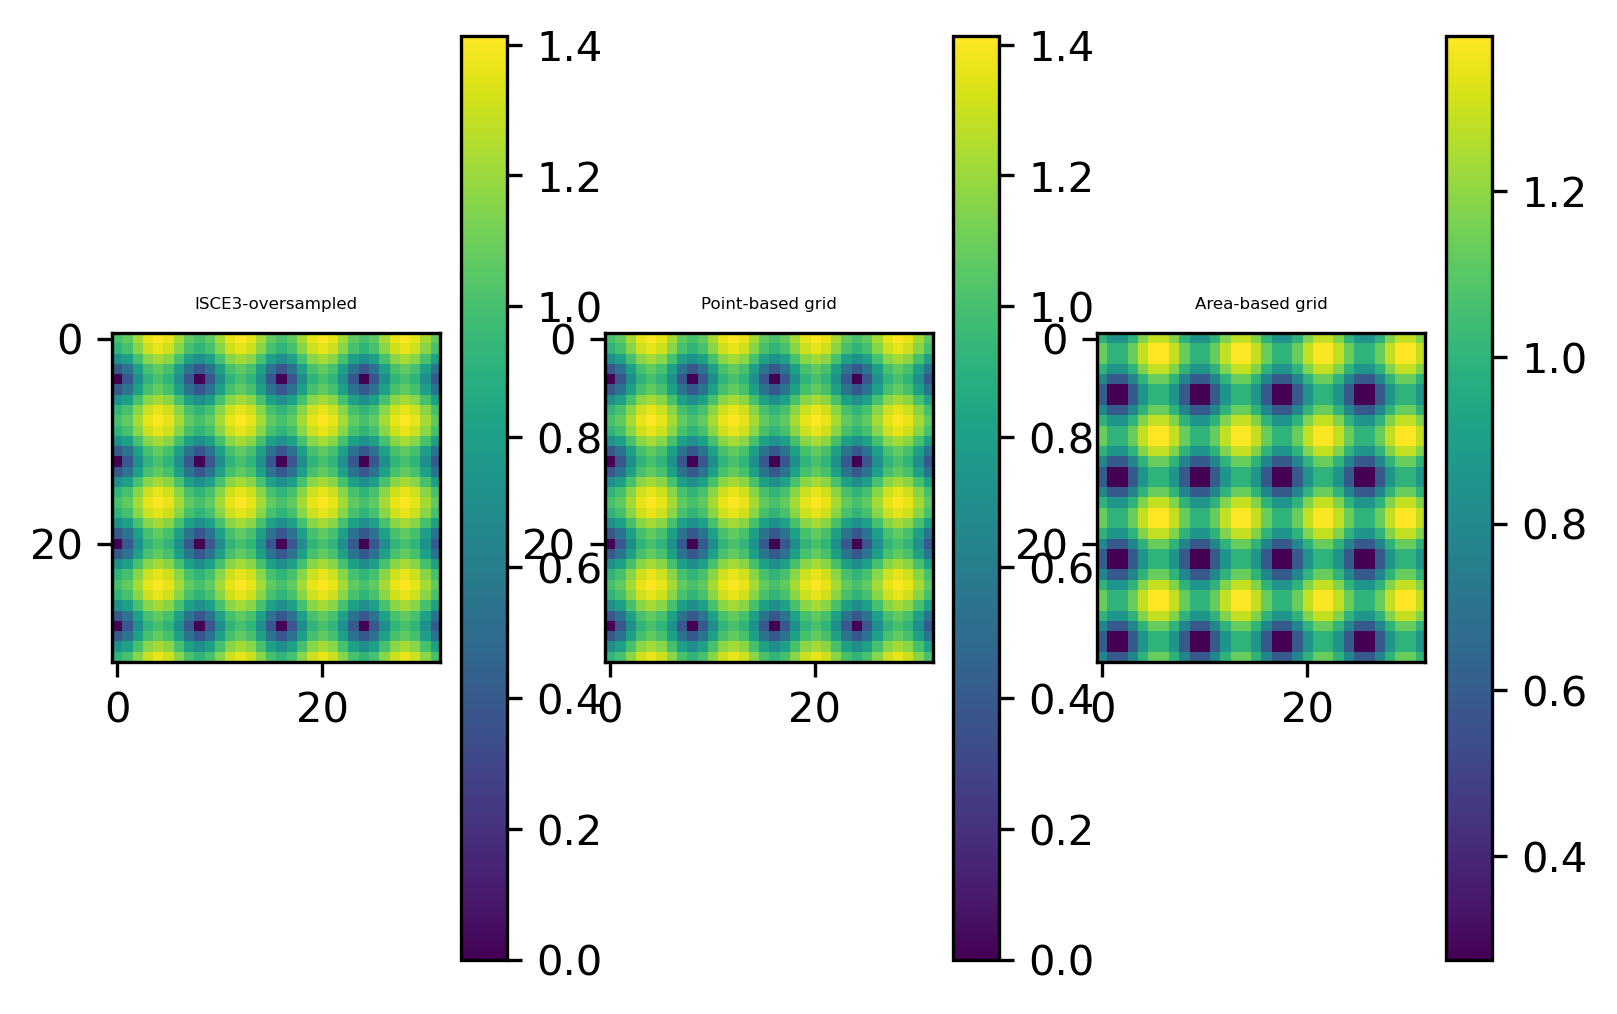

In [20]:
zz_ovs_point = true_signal(xx_ovs_point, yy_ovs_point)
zz_ovs_area = true_signal(xx_ovs_area, yy_ovs_area)

plt.subplot(1,3,1)
plt.imshow(np.abs(zz_ovs_isce3))
plt.title('ISCE3-oversampled', size=4)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.abs(zz_ovs_point))
plt.title('Point-based grid', size=4)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.abs(zz_ovs_area))
plt.title('Area-based grid', size=4)
plt.colorbar()


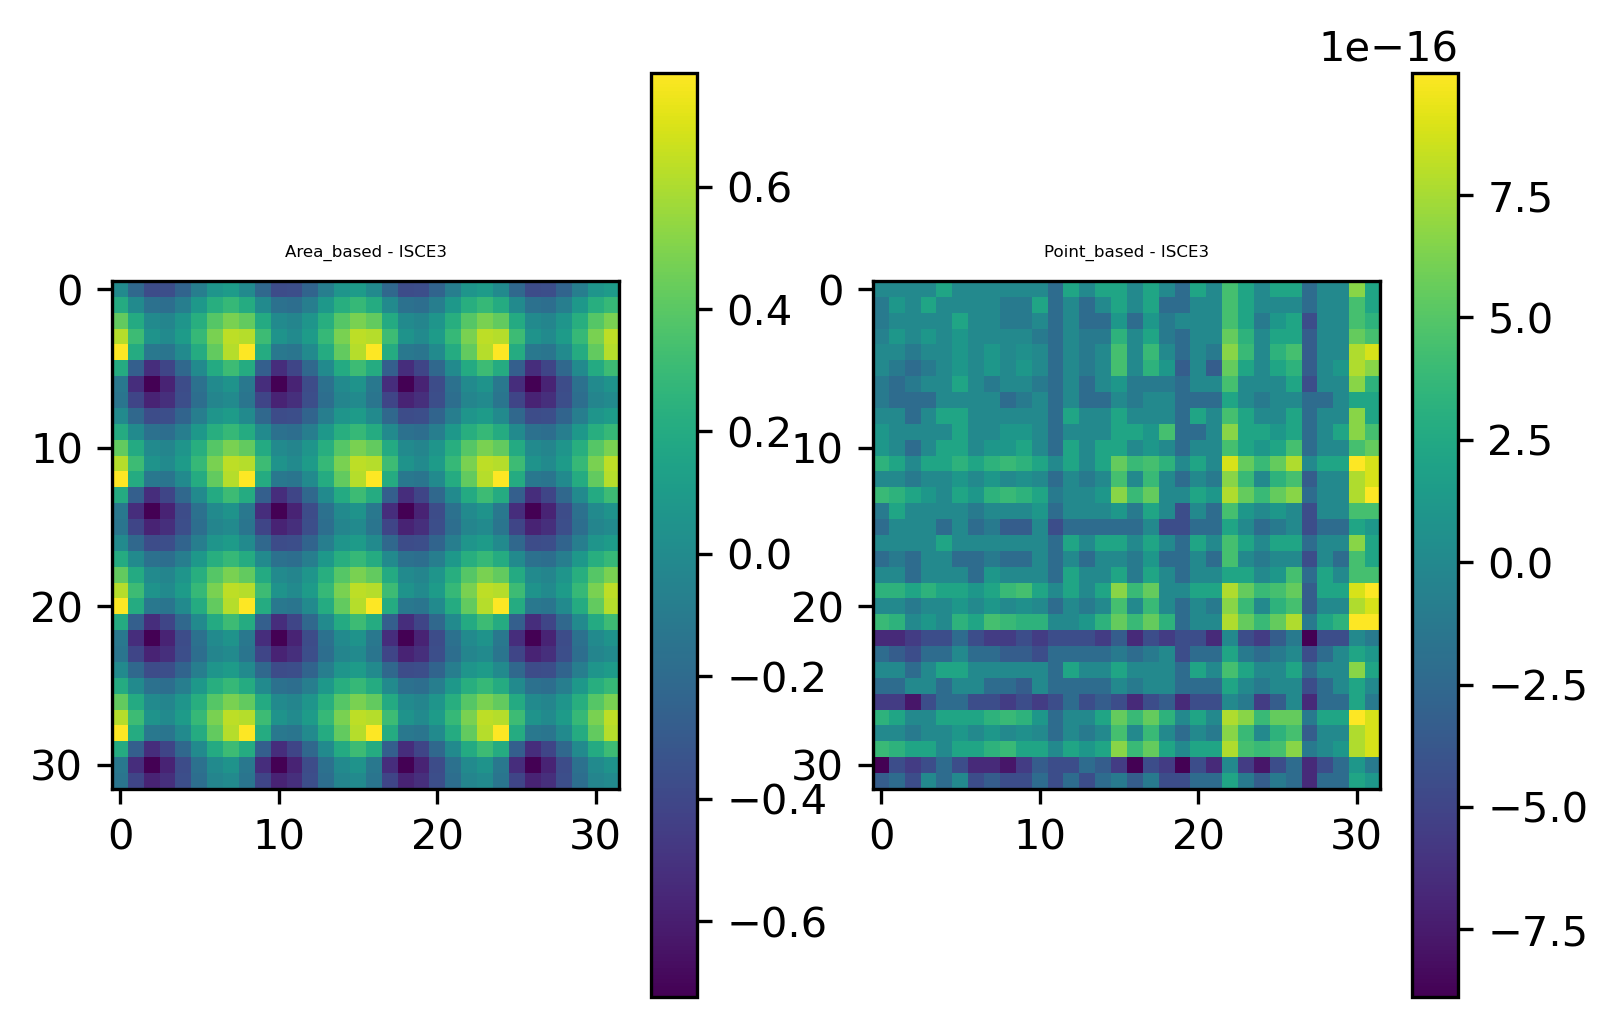

In [21]:
plt.subplot(1,2,1)
plt.imshow(np.abs(zz_ovs_area) - np.abs(zz_ovs_isce3))
plt.title('Area_based - ISCE3', size=4)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.abs(zz_ovs_point) - np.abs(zz_ovs_isce3))
plt.title('Point_based - ISCE3', size=4)
plt.colorbar()

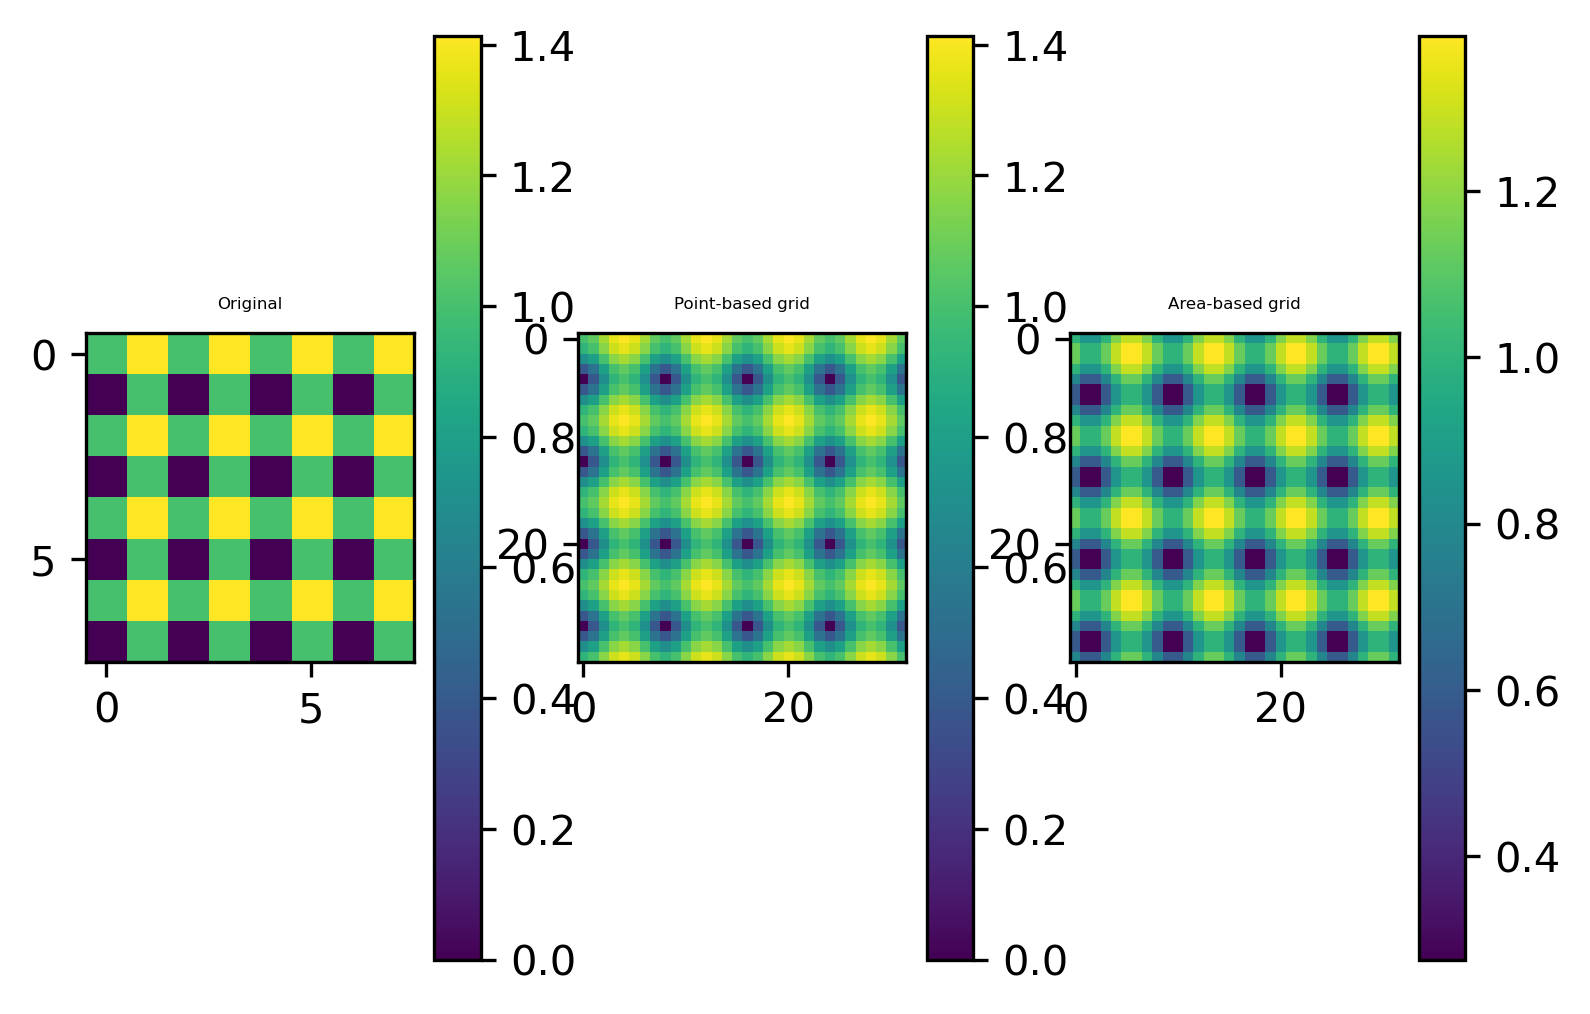

In [22]:
plt.subplot(1,3,1)
plt.imshow(np.abs(zz_original))
plt.title('Original', size=4)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.abs(zz_ovs_point))
plt.title('Point-based grid', size=4)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.abs(zz_ovs_area))
plt.title('Area-based grid', size=4)
plt.colorbar()


The plot above qualitatively suggest that the area-based oversampling grid gives the image whose overall amplitude pattern is more similar to the original image.

The plot below is the comparison with the resampling function in scipy. Note that the plot is in 1-dimensional for better comparison of the oversampled data.
(credit: Heresh Fattahi)

The original samples are oversampled using `scipy.signal.resample()`. When plotting the oversampled result, the x value, which is the oversampling grid, is defined from either point-based index or area-based index. If the plot is using the same oversampling grid as the scipy's resampling function, then the plot of the oversampled signal will be very close to the original signal.

Based on what is shown in the plot, the point index is much closer to the area index. Therefore, we can say that the resampling function in scipy is based on point-based grid.

Text(0.5, 1.0, 'Oversampled by scipy\nfactor=4')

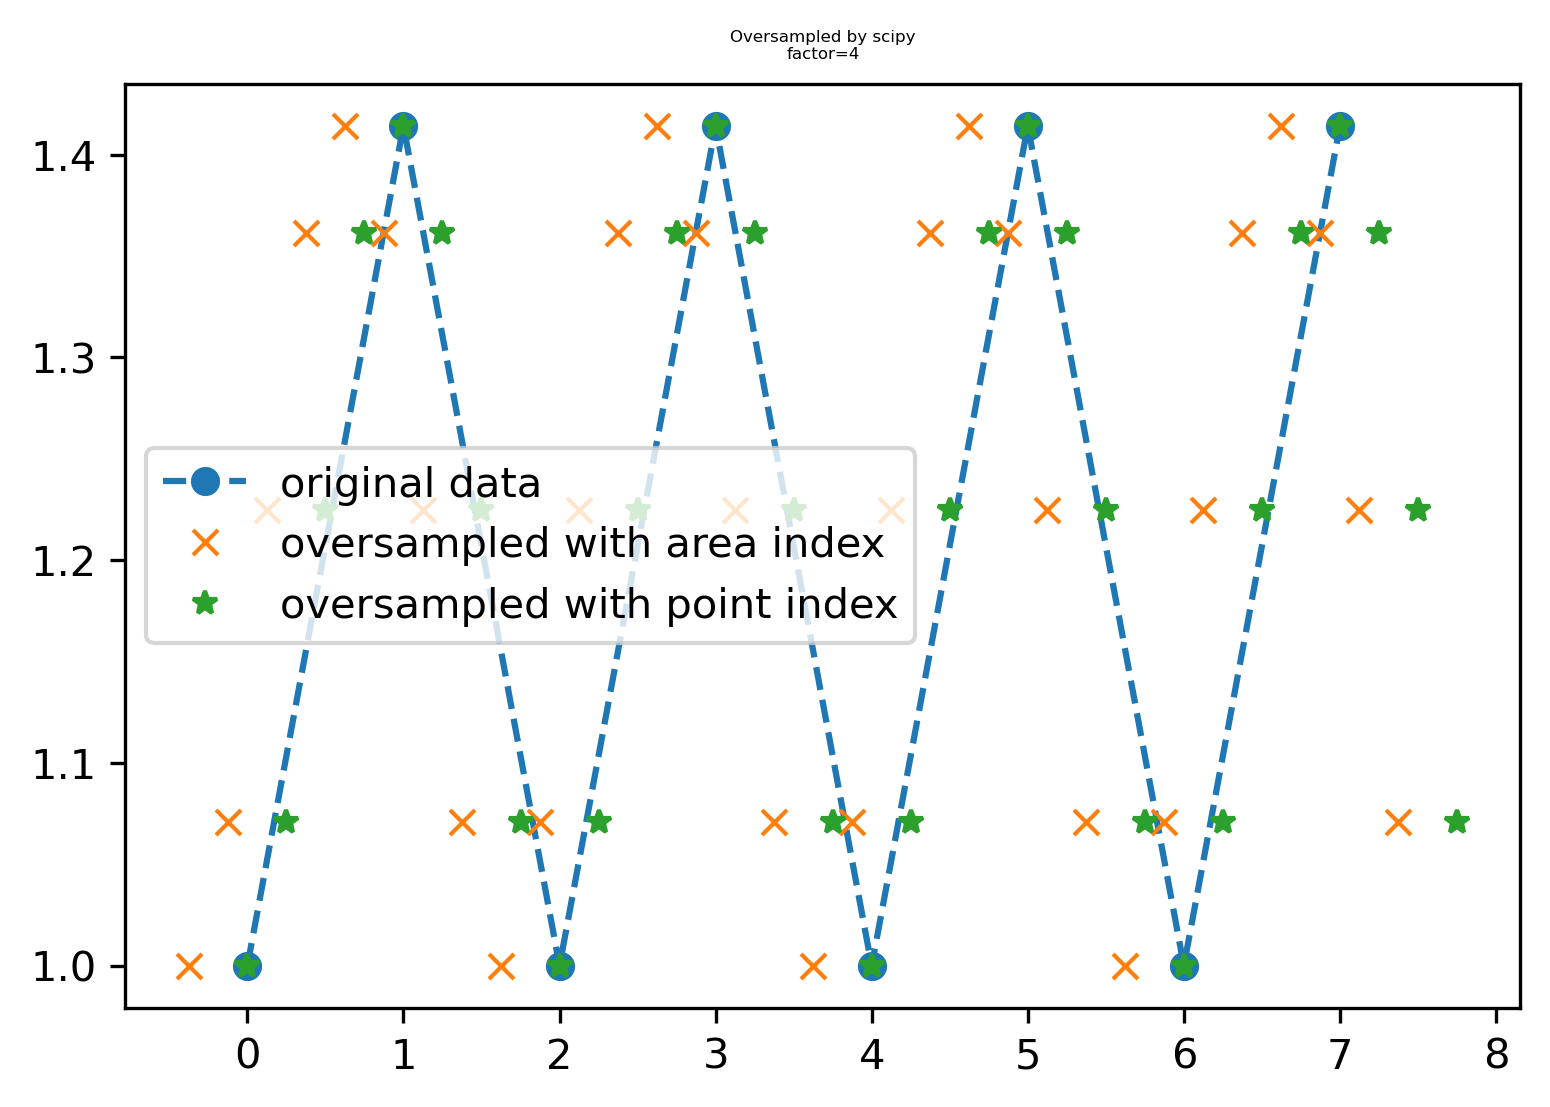

In [25]:
zz_ovs_scipy = signal.resample(zz_original[0,:],  ovs*N)
true_ovs_signal_area = true_signal(x_ovs_area, yy_ovs_area)
true_ovs_signal_point = true_signal(x_ovs_point, yy_ovs_point)
plt.subplot(1,1,1)
plt.plot(x_original, np.abs(zz_original[0,:]),"--o")
plt.plot(x_ovs_area, np.abs(zz_ovs_scipy),"x")
plt.plot(x_ovs_point, np.abs(zz_ovs_scipy),"*")
plt.legend(["original data", "oversampled with area index", "oversampled with point index"])
#plt.colorbar()
plt.title(f'Oversampled by scipy\nfactor={ovs}', size=4)

### Summary up to this point:
1. Area-based oversampling grid gives the sampling result that more resembles the original samples than the point-based oversample grid.
2. Point-based oversampling grid gives almost similar output as `isce3.signal.point_target_info.oversample()`, compared to the area-based grid shows some shifting.

### Conclusion
- in terms of the appearance of the oversampled image, it makes more sense to use area-based oversampling grid
- However, this is not the way how `isce3.signal.point_target_info.oversample()` defines the oversampling grid. The function is based on point-based approach.
- Therefore, if we want to use the output directly from the `oversample()` in ISCE3, The coordinate conversion has to be based on the point-based.